### Some resources

https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

## Some resources: architectures

#### Convolutions
https://ifding.github.io/2018/05/24/1d-2d-and-3d-convolutions-in-cnn/
https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf

https://stackoverflow.com/questions/42883547/intuitive-understanding-of-1d-2d-and-3d-convolutions-in-convolutional-neural-n

In [ ]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [ ]:
import load_files
import models
from load_files import *
from models import *
import numpy as np

In [3]:
x_train, y_train, x_test, y_test = load_dataset('../data/HAR/UCI_HAR_Dataset/')

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [4]:
x_train.shape

(7352, 128, 9)

### activity labels 

1 WALKING

2 WALKING_UPSTAIRS

3 WALKING_DOWNSTAIRS

4 SITTING

5 STANDING

6 LAYING

In [5]:
labels_id = range(6)
labels_names =[ 'WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

In [6]:
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

<IPython.core.display.Javascript object>


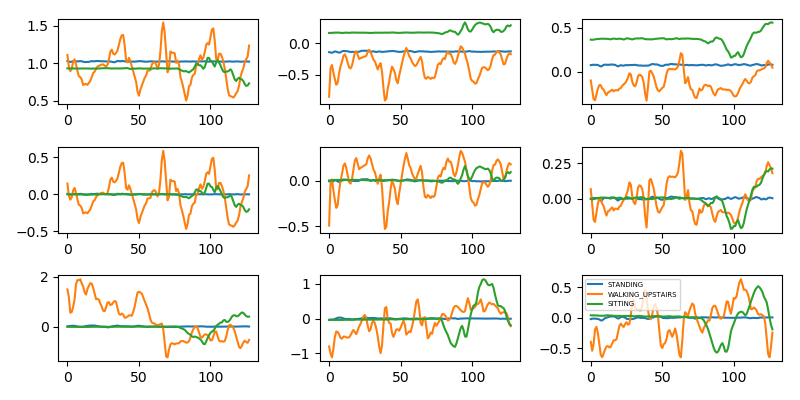

In [54]:
experiments = [10,500,30]

plt.figure(figsize=(8,4))
for i in range(9):
    plt.subplot(3,3,i+1)
    for experiment in experiments:
        plt.plot(x_train[experiment][:,i], label = labels_names[np.argmax(y_train[experiment])])
plt.legend(fontsize=5)
plt.tight_layout()    

keras imports

In [9]:
from keras import Model
from keras.layers import Lambda, Input, Dropout, Flatten, LSTM, Concatenate, Bidirectional, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras import backend as K
from keras.callbacks import TensorBoard
from time import time
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from time import time

# Model generators

here we are going to analyse the performance of diffierent methods to classify the time series

here we define recall and auc metrics that are not implemented in keras

references:

https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras

In [10]:
import custom_metrics; from custom_metrics import as_keras_metric
import tensorflow as tf

auc_roc = as_keras_metric(tf.metrics.auc)
recall = as_keras_metric(tf.metrics.recall)

## Some callbacks

we define some callbacks that we are going to implement during training

https://stackoverflow.com/questions/50874596/how-to-detect-the-epoch-where-keras-earlystopping-occurred

In [11]:
#lr_cb = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, min_delta = 0.01, patience = 3, verbose = 1)
#es_cb = EarlyStopping(monitor = 'val_loss', min_delta=0.01, patience = 10, verbose = 1, restore_best_weights = True)

min_delta_val = 0.01
lr_cb = ReduceLROnPlateau(monitor = 'val_auc', mode='max', 
                          factor = 0.5, min_delta = min_delta_val, patience = 3, verbose = 1)
es_cb = EarlyStopping(monitor = 'val_auc', mode='max', 
                      min_delta=min_delta_val, patience = 10, verbose = 1, restore_best_weights = True)

default_callbacks = [lr_cb, es_cb]

Training parameters

In [12]:
from keras import optimizers

In [13]:
N_train = 1
adam = optimizers.adam(lr=0.01)
validation_split_on_training = 0.2
epochs = 100
batch_size = 1000

In [55]:
import models; from models import *

model_name= '1D_CNN'


model_input, model_output, _ = dense_model_2_generator(n_timesteps, n_features, n_outputs)

model = Model(model_input, model_output, name = model_name)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', auc_roc, recall])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 9)       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               [(None, 128), (None, 0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           3870        lambda_1[0][0]                   
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30)           3870        lambda_1[0][1]                   
__________________________________________________________________________________________________
dense_5 (D

In [56]:
print_summary_only_once = True
trained_models = []
trained_models_best_epoch = []
trained_models_stats = []
trained_models_time_taken = []

model_name_base = model_name
model_generator = dense_fully_connected_model_generator




for i in range(N_train):
    tic = time()
    model_name = model_name_base + '_' + str(i)
    tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
    callbacks_model = default_callbacks + [tensorboard]

    # generate model
#    model_input, model_output , _ = model_generator(n_timesteps, n_features, n_outputs)
#    model = Model(model_input, model_output, name = model_name)

    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', auc_roc, recall])

    # train model
    model.fit(x_train, 
              y_train, epochs=epochs, 
              batch_size=batch_size, 
              validation_split=validation_split_on_training,
              verbose=True,
              callbacks = callbacks_model)     
    trained_models.append(model)

    # training time
    training_time = time()-tic
    trained_models_time_taken.append(training_time)
    print('training time: {}s'.format(training_time))

    # early stopping epoch
    best_epoch = es_cb.stopped_epoch
    trained_models_best_epoch.append(best_epoch)

    #append best stat
    best_stats = {}
    for key in model.history.history.keys():
        best_stats[key] = model.history.history[key][best_epoch]
    trained_models_stats.append(best_stats)

trained_models_stats = pd.DataFrame(trained_models_stats)

Train on 5881 samples, validate on 1471 samples
Epoch 1/100
5881/5881 [==============================] - 1s 164us/step - loss: 1.5973 - acc: 0.3794 - auc: 0.5004 - recall: 0.8300 - val_loss: 1.1678 - val_acc: 0.5629 - val_auc: 0.7443 - val_recall: 1.0000
Epoch 2/100
5881/5881 [==============================] - 0s 64us/step - loss: 0.9875 - acc: 0.5990 - auc: 0.8079 - recall: 1.0000 - val_loss: 0.7345 - val_acc: 0.7301 - val_auc: 0.8506 - val_recall: 1.0000
Epoch 3/100
5881/5881 [==============================] - 0s 54us/step - loss: 0.6593 - acc: 0.7160 - auc: 0.8752 - recall: 1.0000 - val_loss: 0.6044 - val_acc: 0.7893 - val_auc: 0.8948 - val_recall: 1.0000
Epoch 4/100
5881/5881 [==============================] - 0s 53us/step - loss: 0.5190 - acc: 0.7718 - auc: 0.9074 - recall: 1.0000 - val_loss: 0.5518 - val_acc: 0.8239 - val_auc: 0.9187 - val_recall: 1.0000
Epoch 5/100
5881/5881 [==============================] - 0s 58us/step - loss: 0.4376 - acc: 0.8203 - auc: 0.9268 - recall: 1.00

In [57]:
best_stats

{'val_loss': 0.29983012484580296,
 'val_acc': 0.919782471284017,
 'val_auc': 0.9894676298855276,
 'val_recall': 1.0,
 'loss': 0.10000571743213812,
 'acc': 0.9588505389373778,
 'auc': 0.9892583486681548,
 'recall': 1.0,
 'lr': 6.25e-05}

In [58]:
test_metrics = model.evaluate(x_test, y_test)

print(model.metrics_names)
print(test_metrics)

2947/2947 [==============================] - 0s 69us/step
['loss', 'acc', 'auc', 'recall']
[0.37167871719928447, 0.8775025449609772, 0.9893366802656978, 1.0]


In [59]:
y_pred = model.predict(x_test)

In [60]:
y_pred[0]

array([8.6198517e-05, 2.6136360e-04, 6.3771807e-08, 8.2035881e-04,
       9.9883193e-01, 1.1945065e-07], dtype=float32)

In [61]:
import sklearn


In [62]:
conf_matrix = sklearn.metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

In [63]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<IPython.core.display.Javascript object>


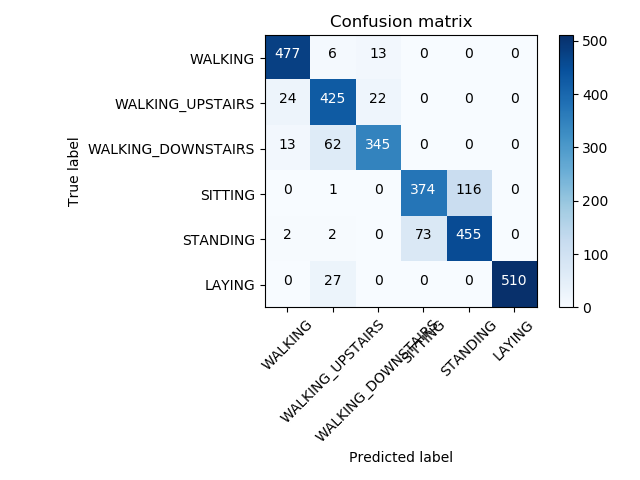

Confusion matrix, without normalization
[[477   6  13   0   0   0]
 [ 24 425  22   0   0   0]
 [ 13  62 345   0   0   0]
 [  0   1   0 374 116   0]
 [  2   2   0  73 455   0]
 [  0  27   0   0   0 510]]


In [64]:
plt.figure()
plot_confusion_matrix(conf_matrix, labels_names)